# Encoder Architecture in LLMs: Step-by-Step Demo

This notebook demonstrates how encoder architectures work in Large Language Models, their significance, and provides interactive visualizations.

In [12]:
# Install packages if needed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Try importing, install if missing
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
except ImportError:
    print("Installing PyTorch...")
    install_package("torch")
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

try:
    from transformers import AutoTokenizer, AutoModel
except ImportError:
    print("Installing transformers...")
    install_package("transformers")
    from transformers import AutoTokenizer, AutoModel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
sns.set_palette("husl")

print("✓ All packages imported successfully")
print(f"PyTorch version: {torch.__version__}")

✓ All packages imported successfully
PyTorch version: 2.8.0


## 1. What is an Encoder?

An encoder transforms input sequences into rich representations that capture semantic meaning. In LLMs:
- **Input**: Raw text tokens
- **Output**: Dense vector representations (embeddings)
- **Purpose**: Create contextual understanding of input

In [13]:
# Simple Encoder Layer Implementation
class SimpleEncoder(nn.Module):
    def __init__(self, d_model=512, nhead=8, dim_feedforward=2048):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # Self-attention with residual connection
        attn_out, attn_weights = self.self_attn(x, x, x)
        x = self.norm1(x + attn_out)
        
        # Feed-forward with residual connection
        ff_out = self.linear2(F.relu(self.linear1(x)))
        x = self.norm2(x + ff_out)
        
        return x, attn_weights

print("✓ Simple Encoder Layer defined")

✓ Simple Encoder Layer defined


## 2. Step-by-Step Encoding Process

In [14]:
# Step 1: Tokenization
sample_text = "The quick brown fox jumps over the lazy dog"
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.encode(sample_text, return_tensors='pt')

print(f"Original text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs shape: {token_ids.shape}")
print(f"Token IDs: {token_ids.squeeze().tolist()}")

Original text: The quick brown fox jumps over the lazy dog
Tokens: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
Token IDs shape: torch.Size([1, 11])
Token IDs: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102]


In [15]:
# Step 2: Embedding Layer
vocab_size = 30522  # BERT vocab size
d_model = 512
embedding = nn.Embedding(vocab_size, d_model)

# Convert tokens to embeddings
token_embeddings = embedding(token_ids)
print(f"Token embeddings shape: {token_embeddings.shape}")
print(f"Each token is now a {d_model}-dimensional vector")

Token embeddings shape: torch.Size([1, 11, 512])
Each token is now a 512-dimensional vector


In [16]:
# Step 3: Positional Encoding
def positional_encoding(seq_len, d_model):
    pos = torch.arange(seq_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                        -(np.log(10000.0) / d_model))
    
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    return pe.unsqueeze(0)

seq_len = token_embeddings.size(1)
pos_encoding = positional_encoding(seq_len, d_model)
input_embeddings = token_embeddings + pos_encoding

print(f"Added positional encoding")
print(f"Final input embeddings shape: {input_embeddings.shape}")

Added positional encoding
Final input embeddings shape: torch.Size([1, 11, 512])


## 3. Encoder Processing & Visualization

In [17]:
# Process through encoder
encoder = SimpleEncoder(d_model=d_model)
encoded_output, attention_weights = encoder(input_embeddings)

print(f"Encoded output shape: {encoded_output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Encoded output shape: torch.Size([1, 11, 512])
Attention weights shape: torch.Size([1, 11, 11])


Attention weights shape: torch.Size([1, 11, 11])


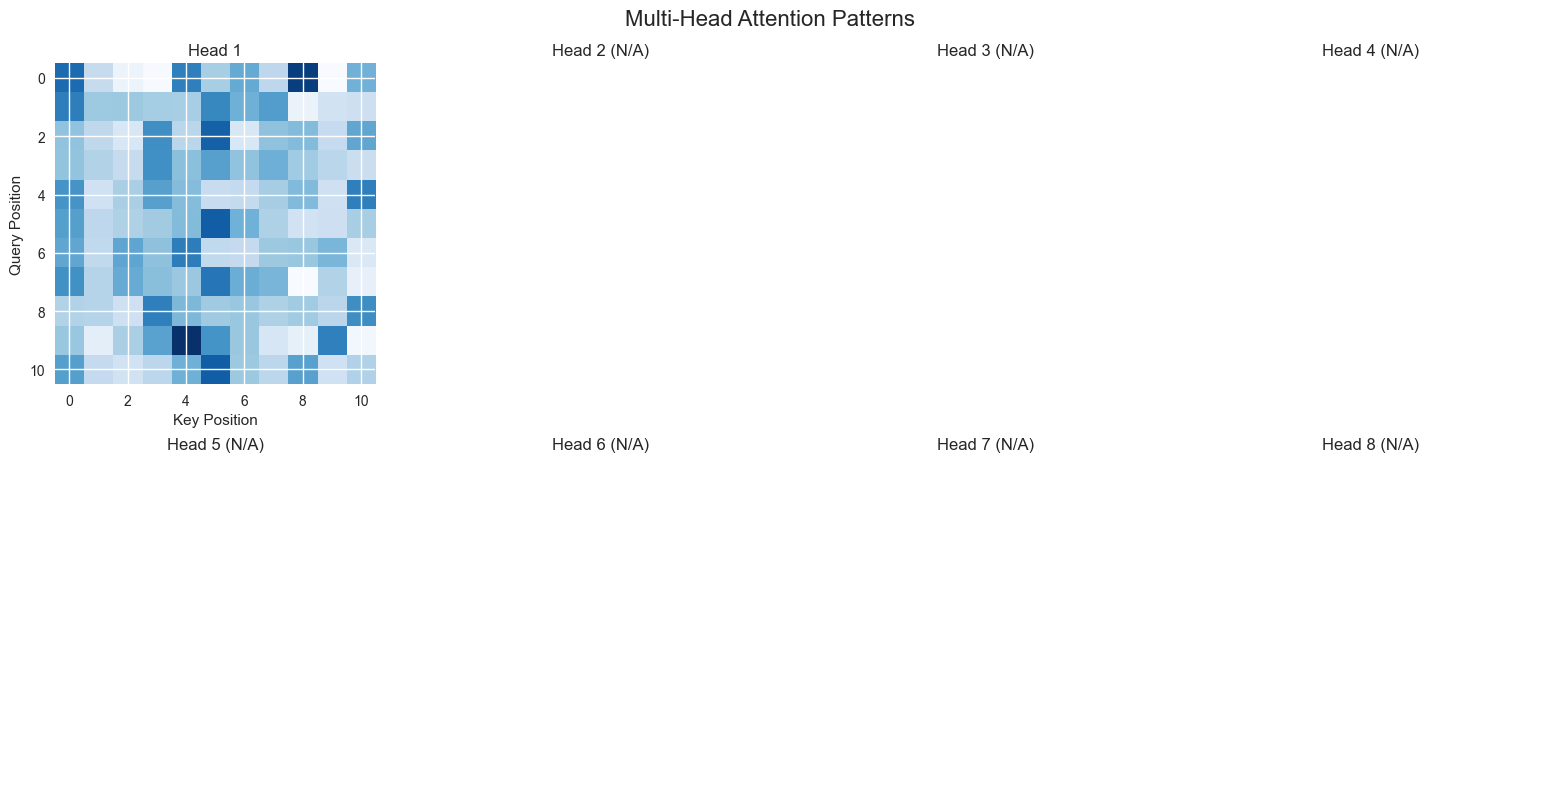

In [18]:
# Visualize attention patterns
print(f"Attention weights shape: {attention_weights.shape}")

# Handle different attention weight formats
if attention_weights.dim() == 4:  # [batch, heads, seq, seq]
    attn_data = attention_weights[0]  # Remove batch dimension
elif attention_weights.dim() == 3:  # [heads, seq, seq]
    attn_data = attention_weights
else:  # [seq, seq] - single head
    attn_data = attention_weights.unsqueeze(0)

num_heads = min(8, attn_data.shape[0])
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Multi-Head Attention Patterns', fontsize=16)

for i in range(8):
    row, col = i // 4, i % 4
    
    if i < num_heads:
        attn_matrix = attn_data[i].detach().numpy()
        im = axes[row, col].imshow(attn_matrix, cmap='Blues')
        axes[row, col].set_title(f'Head {i+1}')
    else:
        axes[row, col].set_title(f'Head {i+1} (N/A)')
        axes[row, col].axis('off')
        continue
    
    axes[row, col].set_xlabel('Key Position')
    axes[row, col].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

## 4. Real-World Example with Pre-trained Model

In [19]:
# Load pre-trained BERT encoder
model = AutoModel.from_pretrained('bert-base-uncased')
model.eval()

# Process multiple sentences
sentences = [
    "The cat sat on the mat",
    "A dog ran in the park", 
    "Birds fly in the sky",
    "Fish swim in the ocean"
]

# Encode sentences
encoded_sentences = []
for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        # Use [CLS] token representation
        sentence_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        encoded_sentences.append(sentence_embedding.flatten())

encoded_sentences = np.array(encoded_sentences)
print(f"Encoded {len(sentences)} sentences")
print(f"Each sentence encoded as {encoded_sentences.shape[1]}-dimensional vector")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Encoded 4 sentences
Each sentence encoded as 768-dimensional vector


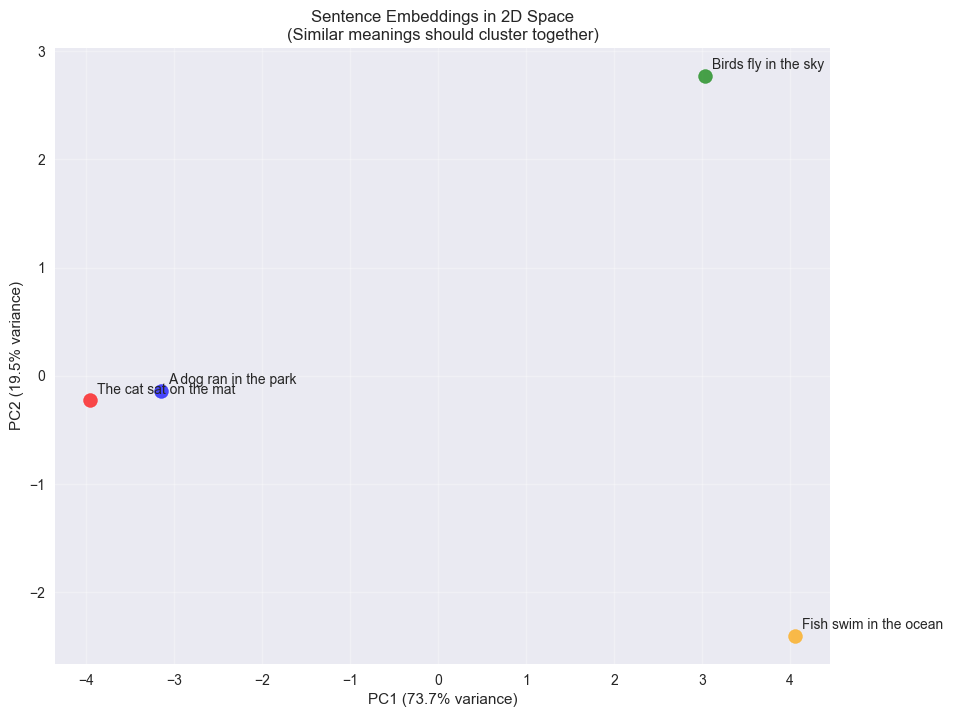

In [20]:
# Visualize sentence embeddings in 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(encoded_sentences)

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange']

for i, (sentence, color) in enumerate(zip(sentences, colors)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 
               c=color, s=100, alpha=0.7)
    plt.annotate(sentence, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title('Sentence Embeddings in 2D Space\n(Similar meanings should cluster together)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Significance of Encoders in LLMs

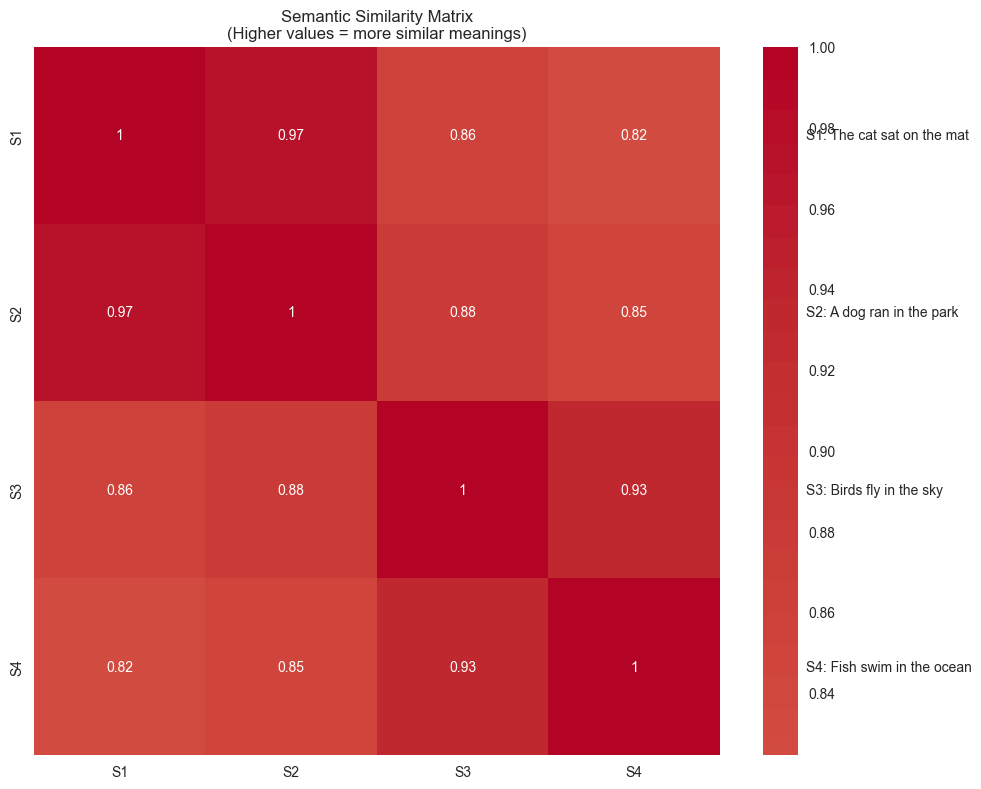

In [21]:
# Demonstrate semantic similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Calculate similarities between sentences
similarity_matrix = np.zeros((len(sentences), len(sentences)))
for i in range(len(sentences)):
    for j in range(len(sentences)):
        similarity_matrix[i, j] = cosine_similarity(encoded_sentences[i], encoded_sentences[j])

# Visualize similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', center=0,
            xticklabels=[f"S{i+1}" for i in range(len(sentences))],
            yticklabels=[f"S{i+1}" for i in range(len(sentences))])
plt.title('Semantic Similarity Matrix\n(Higher values = more similar meanings)')

# Add sentence labels
for i, sentence in enumerate(sentences):
    plt.text(len(sentences) + 0.5, i + 0.5, f"S{i+1}: {sentence}", 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Key Insights & Applications

In [22]:
# Demonstrate layer-wise representations
def get_layer_representations(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    
    # Get [CLS] token representation from each layer
    layer_reps = []
    for layer_output in hidden_states:
        cls_rep = layer_output[:, 0, :].numpy().flatten()
        layer_reps.append(cls_rep)
    
    return np.array(layer_reps)

# Analyze how representations change through layers
test_sentence = "The quick brown fox jumps"
layer_representations = get_layer_representations(test_sentence, model, tokenizer)

print(f"Sentence: '{test_sentence}'")
print(f"Representations through {len(layer_representations)} layers")
print(f"Each layer output: {layer_representations.shape[1]} dimensions")

Sentence: 'The quick brown fox jumps'
Representations through 13 layers
Each layer output: 768 dimensions


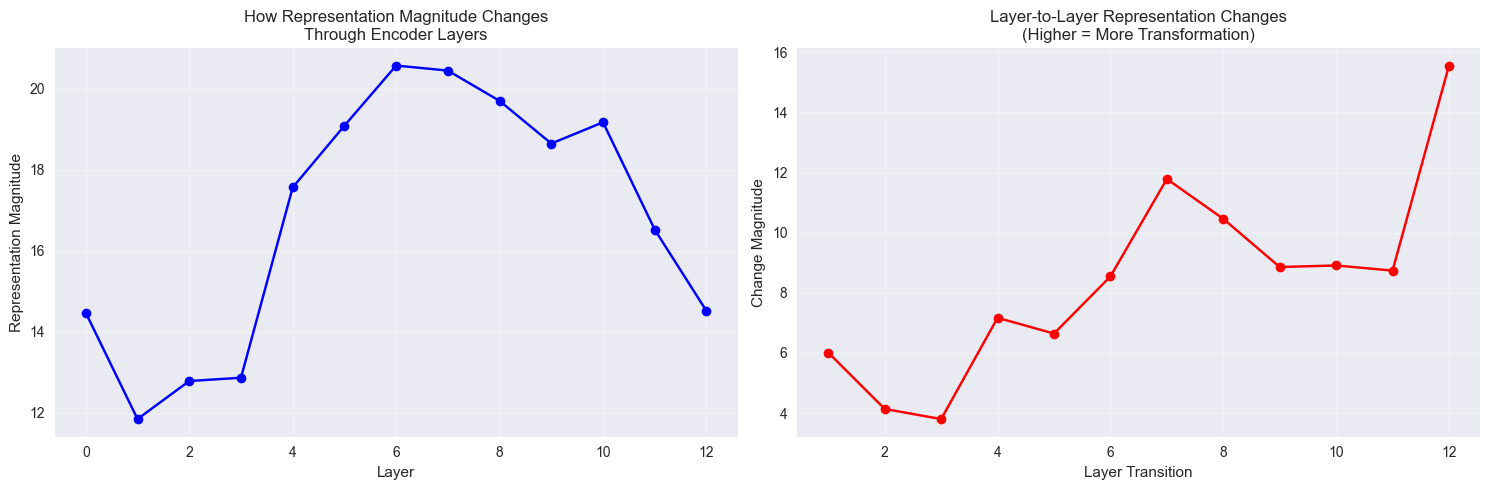

In [23]:
# Visualize how representations evolve through layers
layer_norms = [np.linalg.norm(rep) for rep in layer_representations]
layer_changes = [np.linalg.norm(layer_representations[i] - layer_representations[i-1]) 
                for i in range(1, len(layer_representations))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot representation magnitude through layers
ax1.plot(range(len(layer_norms)), layer_norms, 'bo-')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Representation Magnitude')
ax1.set_title('How Representation Magnitude Changes\nThrough Encoder Layers')
ax1.grid(True, alpha=0.3)

# Plot layer-to-layer changes
ax2.plot(range(1, len(layer_representations)), layer_changes, 'ro-')
ax2.set_xlabel('Layer Transition')
ax2.set_ylabel('Change Magnitude')
ax2.set_title('Layer-to-Layer Representation Changes\n(Higher = More Transformation)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary: Why Encoders Matter in LLMs

**Key Functions:**
1. **Contextual Understanding**: Transform tokens into context-aware representations
2. **Semantic Capture**: Encode meaning, not just syntax
3. **Hierarchical Processing**: Build increasingly abstract representations through layers
4. **Attention Mechanisms**: Focus on relevant parts of input

**Applications:**
- Text classification
- Semantic search
- Question answering
- Language understanding tasks

**Architecture Benefits:**
- Parallel processing (vs sequential RNNs)
- Long-range dependencies
- Transfer learning capabilities
- Scalable to large contexts

In [24]:
print("🎉 Encoder Architecture Demo Complete!")
print("\nKey Takeaways:")
print("• Encoders transform text into meaningful vector representations")
print("• Self-attention allows models to focus on relevant context")
print("• Multiple layers build increasingly abstract representations")
print("• Pre-trained encoders capture rich semantic knowledge")
print("• These representations enable various downstream NLP tasks")

🎉 Encoder Architecture Demo Complete!

Key Takeaways:
• Encoders transform text into meaningful vector representations
• Self-attention allows models to focus on relevant context
• Multiple layers build increasingly abstract representations
• Pre-trained encoders capture rich semantic knowledge
• These representations enable various downstream NLP tasks
